# CLIP

In [2]:
# !unzip data/archive.zip -d data/

In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.functional as F
import tqdm

from torchvision import models
from tqdm import tqdm

Fashion Product Image Dataset: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

In [4]:
import pandas as pd

# Load the data (the csv file has some bad lines)
df = pd.read_csv('data/myntradataset/styles.csv', on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
# Drop the rows with missing values
nan_values = df[df['productDisplayName'].isnull()].index
df = df.dropna(subset=['productDisplayName'])

nan_values

Index([3677, 14291, 17639, 22089, 23484, 37531, 40675], dtype='int64')

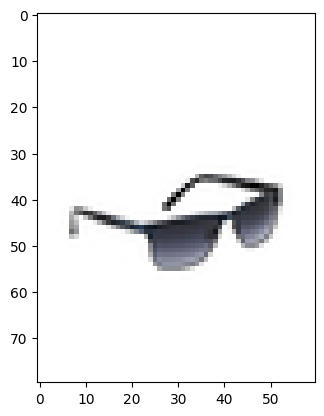

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

images = []

for img in os.listdir('data/myntradataset/images/'):
    if img.endswith('.jpg'):
        id_ = int(img.split('.')[0])

        # Check if the image is in the dataframe
        if not df[df['id'] == id_].empty and id_ not in nan_values:
            image = cv2.imread('data/myntradataset/images/' + img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)

idx = np.random.randint(0, len(images))
plt.imshow(images[idx])

In [7]:
ids_ = df['id'].values
no_images = []

# Ids without images
for id_ in ids_:
    img = cv2.imread('data/myntradataset/images/' + str(id_) + '.jpg')
    if img is None:
        no_images.append(id_)

no_images

[39403, 39410, 39401, 39425, 12347]

In [8]:
from transformers import AutoModel

#inmport bag of words

master_category_bow = {}
article_bow = {}
base_color_bow = {}

counter = 0

for i, row in df.iterrows():
    category = row['masterCategory']
    if category not in master_category_bow:
        master_category_bow[category] = counter
        counter += 1

for i, row in df.iterrows():
    article = row['articleType']
    if article not in article_bow:
        article_bow[article] = counter
        counter += 1

for i, row in df.iterrows():
    color = row['baseColour']
    if color not in base_color_bow:
        base_color_bow[color] = counter
        counter += 1

In [9]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class FashionDataset(Dataset):
    def __init__(self, csv_file, root_dir, train=True, transform=None):
        self.data = pd.read_csv(csv_file, on_bad_lines='skip')
        self.data = self.data.dropna(subset=['masterCategory', 'articleType', 'baseColour'])
        self.data = self.data[~self.data['id'].isin(no_images)]

        self.root_dir = root_dir
        self.transform = transform
        self.train = train

        train_data, test_data = train_test_split(self.data, test_size=0.2, random_state=42)
        self.data = train_data if self.train else test_data
        self.labels = []
        for _, data in self.data.iterrows():
            self.labels.append(np.zeros(len(master_category_bow) + len(article_bow) + len(base_color_bow)))
            row = data
            category = row['masterCategory']
            article = row['articleType']
            color = row['baseColour']

            self.labels[-1][master_category_bow[category]] = master_category_bow[category]
            self.labels[-1][article_bow[article]] = article_bow[article]
            self.labels[-1][base_color_bow[color]] = base_color_bow[color]
            self.labels[-1] = torch.tensor(self.labels[-1], dtype=torch.int32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx, 0]) + ".jpg")
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.reshape(3, 224, 224)
        image = torch.tensor(image, dtype=torch.float32)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
from torchvision import transforms

transform = transforms.Compose([
])

train_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=True, transform=transform), batch_size=32, shuffle=True)
test_dataset = DataLoader(FashionDataset('data/myntradataset/styles.csv', 'data/myntradataset/images/', train=False, transform=transform), batch_size=32, shuffle=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1111
Test dataset size: 278


In [11]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.transformer = AutoModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 512)  # BERT outputs 768-dim embeddings

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(output.pooler_output)

In [12]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.model = models.resnet18(pretrained=True)

        # Freeze the model
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, 512)

    def forward(self, x):
        return self.model(x)

In [13]:
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.07):
    image_embeddings = nn.functional.normalize(image_embeddings, dim=1)
    text_embeddings = nn.functional.normalize(text_embeddings, dim=1)

    logits = torch.mm(image_embeddings, text_embeddings.t()) / temperature
    labels = torch.arange(len(image_embeddings)).to(image_embeddings.device)

    return nn.CrossEntropyLoss()(logits, labels) + nn.CrossEntropyLoss()(logits.t(), labels)

In [14]:
def train(text_encoder, image_encoder, dataloader, optimizer, device, epochs):
    for epoch in range(epochs):
        text_encoder.train()
        image_encoder.train()
        total_loss = 0

        for images, text in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            attention_mask = torch.ones_like(text)
            images = images.to(device)
            text = text.to(device)
            attention_mask = attention_mask.to(device)

            optimizer.zero_grad()

            text_embeddings = text_encoder(text, attention_mask)
            image_embeddings = image_encoder(images)

            loss = contrastive_loss(image_embeddings, text_embeddings)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_model = ImageEncoder().to(device)
text_model = TextEncoder().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(image_model.parameters()) + list(text_model.parameters()), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(text_model, image_model, train_dataset, optimizer, device, 1)

Epoch 1/1: 100%|██████████| 1111/1111 [20:12<00:00,  1.09s/it]

Epoch 1, Loss: 6.929509823221435


In [17]:
# Save our models
torch.save(image_model.state_dict(), 'image_model.pth')
torch.save(text_model.state_dict(), 'text_model.pth')

In [18]:
from torch.nn.functional import cosine_similarity

def test_clip_model(text_encoder, image_encoder, dataloader, device):
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0

    with torch.no_grad():
        for images, text in dataloader:
            attention_mask = torch.ones_like(text)
            images = images.to(device)
            text = text.to(device)
            attention_mask = attention_mask.to(device)

            text_embeddings = text_encoder(text, attention_mask)
            image_embeddings = image_encoder(images)

            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)

            # Accumulate results
            total_similarity += similarity.sum().item()
            count += len(similarity)

    # Compute average similarity
    average_similarity = total_similarity / count
    return average_similarity

In [19]:
test_clip_model(text_model, image_model, test_dataset, device)

-0.2842655707527799

In [20]:
# For a given text index give the k most similar image
def get_most_similar_images(image_encoder, text_encoder, dataloader, text, device, top_k=5):
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0

    text = torch.stack([text])

    attention_mask = torch.ones_like(text)
    text = text.to(device)
    attention_mask = attention_mask.to(device)
    text_embeddings = text_encoder(text, attention_mask)

    top_similar_images = []
    top_similarities = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            attention_mask = attention_mask.to(device)

            image_embeddings = image_encoder(images)

            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)

            for img, sim in zip(images, similarity):
                if len(top_similar_images) < top_k:
                    top_similar_images.append(img)
                    top_similarities.append(sim.item())
                else:
                    if sim > top_similarities[-1]:
                        top_similar_images[-1] = img

                # Sort
                top_similar_images, top_similarities = zip(*sorted(zip(top_similar_images, top_similarities), key=lambda x: x[1], reverse=True))
                top_similar_images = list(top_similar_images)
                top_similarities = list(top_similarities)

    return top_similar_images, top_similarities

In [32]:
idx = np.random.randint(0, len(test_dataset))
image, text = test_dataset.dataset[idx]

k_similar_img, _ = get_most_similar_images(image_model, text_model, test_dataset, text, device, top_k=5)

Accessories Socks Brown


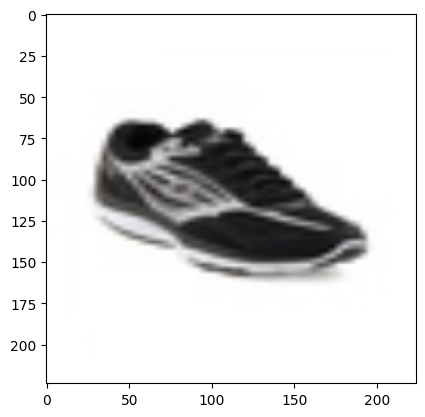

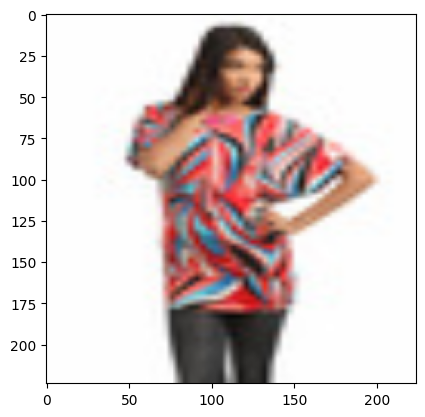

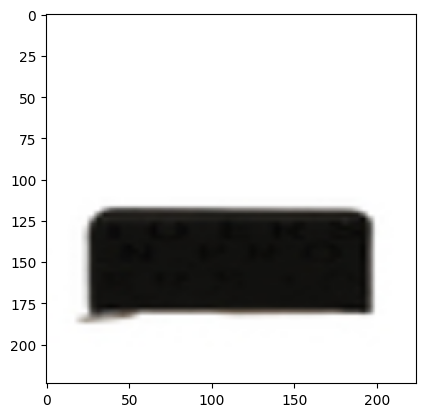

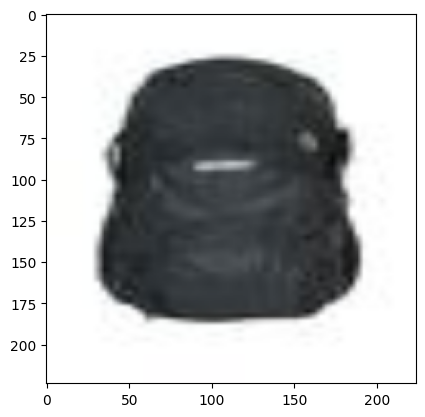

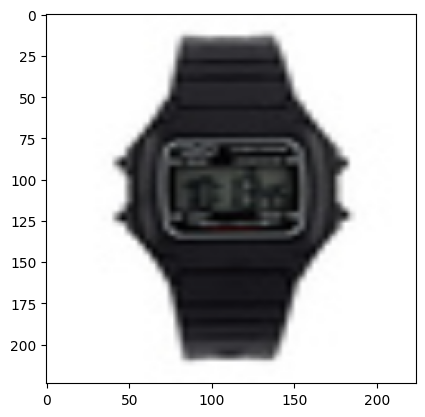

In [38]:
print(test_dataset.dataset.data.iloc[idx, 2], test_dataset.dataset.data.iloc[idx, 4], test_dataset.dataset.data.iloc[idx, 5])

for img in k_similar_img:
    img = img.reshape(224, 224, 3)
    img = img.to('cpu').numpy()
    plt.imshow(img.astype(np.uint8))
    plt.show()

In [34]:
# For a given image index give the 5 most similar description
def get_most_similar_texts(image_encoder, text_encoder, dataloader, image, device, top_k=5):
    text_encoder.eval()
    image_encoder.eval()
    total_similarity = 0.0
    count = 0

    image = torch.stack([image])

    image = image.to(device)
    image_embeddings = image_encoder(image)

    top_similar_texts = []
    top_similarities = []

    with torch.no_grad():
        for _, texts in dataloader:
            attention_mask = torch.ones_like(texts)
            texts = texts.to(device)
            attention_mask = attention_mask.to(device)

            text_embeddings = text_encoder(texts, attention_mask)

            # Compute cosine similarity
            similarity = cosine_similarity(image_embeddings, text_embeddings, dim=1)

            for txt, sim in zip(texts, similarity):
                if len(top_similar_texts) < top_k:
                    top_similar_texts.append(txt)
                    top_similarities.append(sim.item())
                else:
                    if sim > top_similarities[-1]:
                        top_similar_texts[-1] = txt

                # Sort
                top_similar_texts, top_similarities = zip(*sorted(zip(top_similar_texts, top_similarities), key=lambda x: x[1], reverse=True))
                top_similar_texts = list(top_similar_texts)
                top_similarities = list(top_similarities)

    return top_similar_texts, top_similarities

In [35]:
k_similar_txt, _ = get_most_similar_texts(image_model, text_model, test_dataset, image, device, top_k=5)

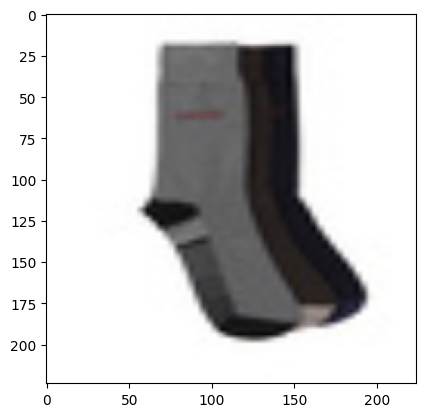

--------
Apparel
Shirts
Black
--------
Footwear
Sports Shoes
White
--------
Personal Care
Face Wash and Cleanser
White
--------
Footwear
Flats
Mustard
--------
Accessories
Belts
Brown


In [36]:
img = image.reshape(224, 224, 3)
img = img.to('cpu').numpy()
plt.imshow(img.astype(np.uint8))
plt.show()

for txt in k_similar_txt:
  print("--------")
  flag = False
  for key, value in master_category_bow.items():
    if value in txt and value!= 0:
      flag = True
      print(key)
  if not flag:
    print("Apparel")
  for key, value in article_bow.items():
    if value in txt and value!= 0:
      print(key)
  for key, value in base_color_bow.items():
    if value in txt and value!= 0:
      print(key)